# Testing GT catalogue load

Objectives:
    1. Test GT simulation waveform loaded through nrc-catalogue-tools.

## Load the library

In [104]:
import os, sys

os.putenv("LAL_DATA_PATH",
          "/media/prayush/Data/src/lalsuite-extra/data/lalsimulation")

#p1 = "/home/vaishakp/Codes/custom_libraries/nr-catalog-tools"
libpath = '/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/nr-catalog-tools'

if libpath not in sys.path:
    sys.path.append(libpath)

print(sys.path)

import h5py
import lal
import lalsimulation as lalsim
from pycbc import pnutils
from pycbc.waveform import get_td_waveform

from matplotlib import pyplot
import numpy

import numpy as np
import sxs
import matplotlib.pyplot as plt

import nrcatalogtools
import nrcatalogtools.lvc as lalutils

from nrcatalogtools.lvc import get_lal_mode_dictionary_from_lmax
from nrcatalogtools import (MayaCatalog, RITCatalog, SXSCatalog)
from nrcatalogtools import utils
from nrcatalogtools.waveform import WaveformModes

['/home/prayush/src/nr-catalog-tools/test/notebooks', '/home/prayush/src/pysurrogate', '/home/prayush/src/nr-catalog-tools/test/notebooks', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python310.zip', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/lib-dynload', '', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages', '/home/prayush/miniconda3/envs/lalsuite-dev-sxs/lib/python3.10/site-packages/nrcatalogtools-0.0.1-py3.10.egg', '/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/nr-catalog-tools']


## Display the environment

In [2]:
%%bash
python --version
conda info --envs | grep '*'

Python 3.10.10
lalsuite-dev-sxs      *  /home/prayush/miniconda3/envs/lalsuite-dev-sxs


# Method I : through nr-catalogue-tools

In [6]:
# View SXS cache
sxs.sxs_directory("cache")

PosixPath('/home/prayush/.cache/sxs')

### MAYA cat details

In [7]:
nrcatalogtools.utils.maya_catalog_info

{'cache_dir': PosixPath('/home/prayush/.cache/MAYA'),
 'url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files',
 'metadata_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/catalog-table.txt',
 'data_dir': PosixPath('/home/prayush/.cache/MAYA/data'),
 'metadata_dir': PosixPath('/home/prayush/.cache/MAYA/metadata'),
 'data_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files'}

In [110]:
# Simulation name
sim_name = 'GT0001'

# Parameters
M = 40
D = 1000
inc = np.pi/3 - 1e-1
coa_phase = np.pi/4
delta_t = 1./2048

## Load waveform

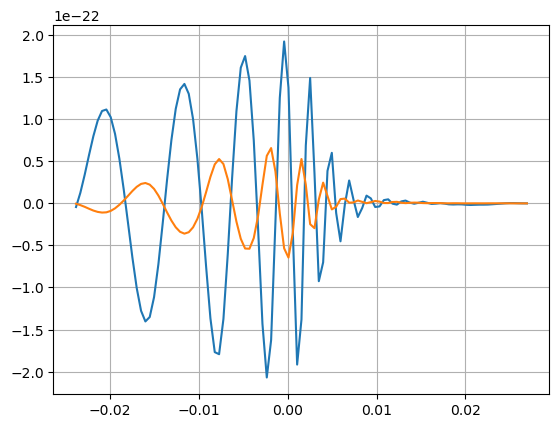

In [98]:
#sc = sxs.Catalog.load(download=True)
#rc = RITCatalog.load(verbosity=5, download=True)
mc = MayaCatalog.load(verbosity=5)

mwf = mc.get(sim_name)
hpc = mwf.get_td_waveform(total_mass=M, distance=D, inclination=inc,
                    coa_phase=coa_phase, delta_t=delta_t
                    )
hpc_pycbc = hpc # mwf.to_pycbc(hpc)
hp, hc = hpc_pycbc.real(), -1 * hpc_pycbc.imag()

plt.plot(hp.sample_times, hp)
plt.plot(hc.sample_times, hc)
plt.grid()
plt.show()

In [99]:
def f_lower_at_1Msun(mwf):
    from pycbc.types import TimeSeries
    from pycbc.waveform import frequency_from_polarizations

    mode22 = mwf.get_mode(2, 2)
    fr22 = frequency_from_polarizations(
        TimeSeries(mode22[:, 1], delta_t=np.diff(mwf.time)[0]),
        TimeSeries(-1 * mode22[:, 2], delta_t=np.diff(mwf.time)[0]))
    return fr22[0] / lal.MTSUN_SI

In [100]:
f_lower_at_1Msun(mwf)

3645.495188807208

Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


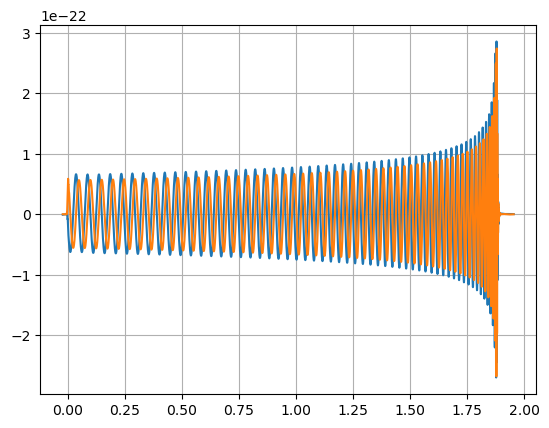

In [112]:
sc = SXSCatalog.load(download=True)

sim_name = 'SXS:BBH:0001'

swf = sc.get(sim_name)
hpc = swf.get_td_waveform(total_mass=M,
                          distance=D,
                          inclination=inc,
                          coa_phase=coa_phase,
                          delta_t=delta_t)
hpc_pycbc = hpc
hp, hc = hpc_pycbc.real(), -1 * hpc_pycbc.imag()

plt.plot(hp.sample_times, hp)
plt.plot(hc.sample_times, hc)
plt.grid()
plt.show()

In [114]:
sc.waveform_filepath_from_simname(sim_name)

NotImplementedError: COMING SOON!

# Method II :

Using [the script](https://github.com/cevans216/gt-waveform-catalog/tree/master/scripts)

## Original script, no changes

Here, `coa_phase` is missing from h5 file's attributes. Correcting for this and loading the same simulation as in the catalogue load, 

In [58]:
file = '/home/prayush/src/nr-catalog-tools/test/GT0001.h5'
with h5py.File(file, 'a') as f:
    f.attrs['f_lower_at_1MSUN'] = f_lower_at_1Msun(mwf)


In [118]:
os.putenv("HDF5_USE_FILE_LOCKING", "FALSE")

In [121]:
file = '/home/prayush/src/nr-catalog-tools/test/GT0001.h5'
with h5py.File(file, 'r') as f:
    for a in f.attrs:
        if 'hat' in a:
            print(a, f.attrs[a])

LNhatx 0.0
LNhaty 0.0
LNhatz 1.0
nhatx -1.0
nhaty 0.0
nhatz 0.0


In [130]:
lalsim.SimInspiralNRWaveformGetDataFromHDF5File?

Object `lalsim.SimInspiralNRWaveformGetDataFromHDF5File` not found.


In [115]:
import h5py
import lal
import lalsimulation as lalsim
from pycbc import pnutils

fdir = nrcatalogtools.utils.maya_catalog_info['cache_dir']
# file = f'{fdir}/data/{sim_name}.h5'
file = '/home/prayush/.cache/sxs/SXS:BBH:0001v3/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5'
# file = '/home/prayush/src/nr-catalog-tools/test/GT0001.h5'

# Check by changing spin by small amount
#dspins2x = np.linspace(-0.1, 0.1, 1000)

with h5py.File(file, 'r') as f:
    #print(f.attrs.keys())
    #print(f.keys())
    params = {}

    # Extrinsic parameters:
    f_lower = f.attrs['f_lower_at_1MSUN'] / M

    params['f_lower'] = f_lower
    params['mtotal'] = M  #150.0
    params['inclination'] = inc  #0.0
    params['distance'] = D  #100.0

    # Metadata parameters:

    params['eta'] = f.attrs['eta']

    params['mass1'] = pnutils.mtotal_eta_to_mass1_mass2(
        params['mtotal'], params['eta'])[0]
    params['mass2'] = pnutils.mtotal_eta_to_mass1_mass2(
        params['mtotal'], params['eta'])[1]

    # BH1 spins
    params['spin1x'] = -f.attrs['spin1x']
    params['spin1y'] = f.attrs['spin1y']
    params['spin1z'] = f.attrs['spin1z']

    # BH2 spins

    #for dspin2x in dspins2x:

    #print(spin2x)
    params['spin2x'] = -f.attrs['spin2x']
    params['spin2y'] = f.attrs['spin2y']
    params['spin2z'] = f.attrs['spin2z']

    # Check for coa_phase, else use the phase from nr cat load.
    try:
        params['coa_phase'] = f.attrs['coa_phase']
    except:
        print(
            f'Cannot find the attribute `coa_phase` in the file. Setting to {coa_phase}'
        )
        #raise AttributeError('Cannot find the attribute `coa_phase` in the file')
        params['coa_phase'] = coa_phase

print('Loading waveform')
hp, hc = get_td_waveform(approximant='NR_hdf5',
                         numrel_data=file,
                         mass1=params['mass1'],
                         mass2=params['mass2'],
                         spin1x=params['spin1x'],
                         spin1y=params['spin1y'],
                         spin1z=params['spin1z'],
                         spin2x=params['spin2x'],
                         spin2y=params['spin2y'],
                         spin2z=params['spin2z'],
                         delta_t=delta_t,
                         f_lower=f_lower,
                         inclination=params['inclination'],
                         coa_phase=params['coa_phase'],
                         distance=params['distance'])

# Get polarizations from the waveformModes object
hp2, hc2 = hpc_pycbc.real(), 1 * hpc_pycbc.imag()

pyplot.figure()
plt.plot(hp.sample_times, hp, '-x', color=[0, 0.7071, 1], label='using GT code')
plt.plot(hp2.sample_times, hp2, '-x', label='using custom code')
plt.legend()

pyplot.figure()
plt.plot(hc.sample_times,
         hc,
         '-x',
         color=[0, 0.7071, 1],
         label='using GT code')
plt.plot(hc2.sample_times, hc2, '-x', label='using custom code')
plt.legend()


KeyError: "Unable to synchronously open attribute (can't locate attribute: 'f_lower_at_1MSUN')"

In [69]:
t

array([0.        , 0.00048828, 0.00097656, 0.00146484, 0.00195312,
       0.00244141, 0.00292969, 0.00341797, 0.00390625, 0.00439453,
       0.00488281, 0.00537109, 0.00585938, 0.00634766, 0.00683594,
       0.00732422, 0.0078125 , 0.00830078, 0.00878906, 0.00927734,
       0.00976562, 0.01025391, 0.01074219, 0.01123047, 0.01171875,
       0.01220703, 0.01269531, 0.01318359, 0.01367188, 0.01416016,
       0.01464844, 0.01513672, 0.015625  , 0.01611328, 0.01660156,
       0.01708984, 0.01757812, 0.01806641, 0.01855469, 0.01904297,
       0.01953125, 0.02001953, 0.02050781, 0.02099609, 0.02148438,
       0.02197266, 0.02246094, 0.02294922, 0.0234375 , 0.02392578,
       0.02441406, 0.02490234, 0.02539062, 0.02587891, 0.02636719,
       0.02685547, 0.02734375, 0.02783203, 0.02832031, 0.02880859,
       0.02929688, 0.02978516, 0.03027344, 0.03076172, 0.03125   ,
       0.03173828, 0.03222656, 0.03271484, 0.03320312, 0.03369141,
       0.03417969, 0.03466797, 0.03515625, 0.03564453, 0.03613

In [95]:
def TransformSpins(nrSpin1, nrSpin2, n_hat, ln_hat):
    ''' Trnasform the spins of the NR simulation to the _ frame.
    Parameters
    ----------
    nrSpin1, nrSpin2 : list
             A list of the components of the spins of the objects.
    nhat, ln_hat : list
             A list of the components of the unit vectors of the objects, 
             against which the components of the spins are specified.
    Returns
    -------
    S1, S2 : list
             The transformed spins.
    '''

    S1x = nrSpin1x * n_hat_x + nrSpin1y * n_hat_y + nrSpin1z * n_hat_z

    S1y = nrSpin1x * (-ln_hat_z * n_hat_y + ln_hat_y * n_hat_z) + nrSpin1y * (
        ln_hat_z * n_hat_x - ln_hat_x * n_hat_z) + nrSpin1z * (
            -ln_hat_y * n_hat_x + ln_hat_x * n_hat_y)

    S1z = nrSpin1x * ln_hat_x + nrSpin1y * ln_hat_y + nrSpin1z * ln_hat_z

    S2x = nrSpin2x * n_hat_x + nrSpin2y * n_hat_y + nrSpin2z * n_hat_z
    S2y = nrSpin2x * (-ln_hat_z * n_hat_y + ln_hat_y * n_hat_z) + nrSpin2y * (
        ln_hat_z * n_hat_x - ln_hat_x * n_hat_z) + nrSpin2z * (
            -ln_hat_y * n_hat_x + ln_hat_x * n_hat_y)

    S2z = nrSpin2x * ln_hat_x + nrSpin2y * ln_hat_y + nrSpin2z * ln_hat_z

    S1 = [S1x, S1y, S1z]
    S2 = [S2x, S2y, S2z]

    return S1, S2